# 04 Custom Data Set Class

In [94]:
import requests
import numpy as np
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import os
import pandas as pd
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn
from torchmetrics import Accuracy, ConfusionMatrix
import mlxtend
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
from mlxtend.plotting import plot_confusion_matrix
import random
import zipfile
from PIL import Image


In [2]:
# !pip install tqdm 


In [3]:
# !pip install tqdm 
# !nvcc --version
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# import torch
# torch.__version__


In [4]:
# set up gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42
device

'cuda'

In [151]:
# get data
# assert int(torch.__version__.split('.')[1]) >=11
# assert int(torchvision._version__.split('.')[1]) >= 11
# data_dir = pathlib.Path("../data")

# !nvidia-smi

parent_data_path = Path ('../data')
os.path.abspath(data_dir)

'c:\\Users\\Hassan\\Dropbox\\GithubRepo\\Udemy\\pytorch-deep-learning-main\\pytorch-deep-learning-main - Copy\\data'

In [6]:
# int(torch.__version__.split('.')[1])
# int(torchvision._version__.split('.')[1])
# Setup data directory

import pathlib
data_path = Path("data/")
data_path = Path("../data/")
data_dir = pathlib.Path("../data")
# image_path = data_path/"pizza steak sushi"
image_path = data_path/"pizza steak sushi"
if image_path.is_dir():
    print (f'{image_path} directory already exists.. skipping download')
else:
    print (f'{image_path} does not exisit creting one..')
    image_path.mkdir(parents = True, exist_ok = True)

#
with zipfile.ZipFile(data_dir /'pizza_steak_sushi.zip', 'r') as zip_ref:
    print ('Unzipping pizz, steak  and sushi')
    zip_ref.extractall(image_path)
    
test_path = data_dir /'pizza_steak_sushi.zip'
test_path

data\pizza steak sushi directory already exists.. skipping download
Unzipping pizz, steak  and sushi


WindowsPath('../data/pizza_steak_sushi.zip')

## explore function


In [152]:
os.path.abspath(image_path)

data_path = Path("../data/")
data_dir = pathlib.Path("../data")

In [153]:
# explore directoy
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk (dir_path):
        print (f'end=There are {len(dirnames)} and directories {len (filenames)} images in {dirpath}.')

data_dir = pathlib.Path("../data")
# image_path = data_path /"pizza steak sushi"
image_path = data_path /"pizza_steak_sushi_20_percent"
walk_through_dir(image_path)

end=There are 2 and directories 0 images in ..\data\pizza_steak_sushi_20_percent.
end=There are 3 and directories 0 images in ..\data\pizza_steak_sushi_20_percent\test.
end=There are 0 and directories 46 images in ..\data\pizza_steak_sushi_20_percent\test\pizza.
end=There are 0 and directories 58 images in ..\data\pizza_steak_sushi_20_percent\test\steak.
end=There are 0 and directories 46 images in ..\data\pizza_steak_sushi_20_percent\test\sushi.
end=There are 3 and directories 0 images in ..\data\pizza_steak_sushi_20_percent\train.
end=There are 0 and directories 154 images in ..\data\pizza_steak_sushi_20_percent\train\pizza.
end=There are 0 and directories 146 images in ..\data\pizza_steak_sushi_20_percent\train\steak.
end=There are 0 and directories 150 images in ..\data\pizza_steak_sushi_20_percent\train\sushi.


In [154]:
# set up train test path
train_dir = image_path /'train'
test_dir = image_path/'test'

train_dir, test_dir

(WindowsPath('../data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('../data/pizza_steak_sushi_20_percent/test'))

Image height: 512
Image width: 512


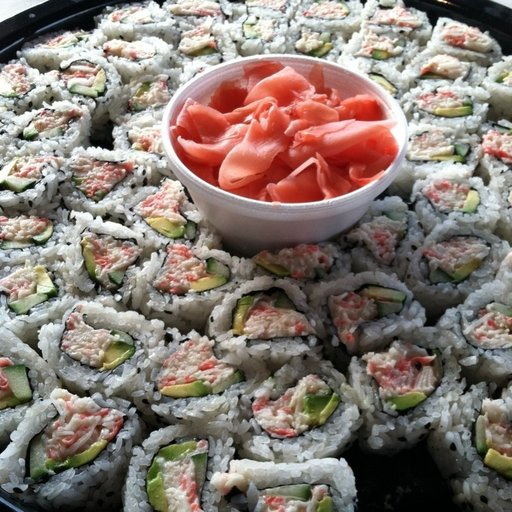

In [155]:
# explore data
random.seed(42)
image_path_list = list (image_path.glob ('*/*/*.jpg'))
image_path_list 
random_image_path = random.choice (image_path_list)
random_image_path
image_class = random_image_path.parent.stem
image_class
img = Image.open(random_image_path)
print (f'Image height: {img.height}')
print (f'Image width: {img.width}')
img

## Code to show set of pictures

(384, 512, 3)
(512, 511, 3)
(383, 512, 3)
(512, 512, 3)
(512, 382, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 306, 3)


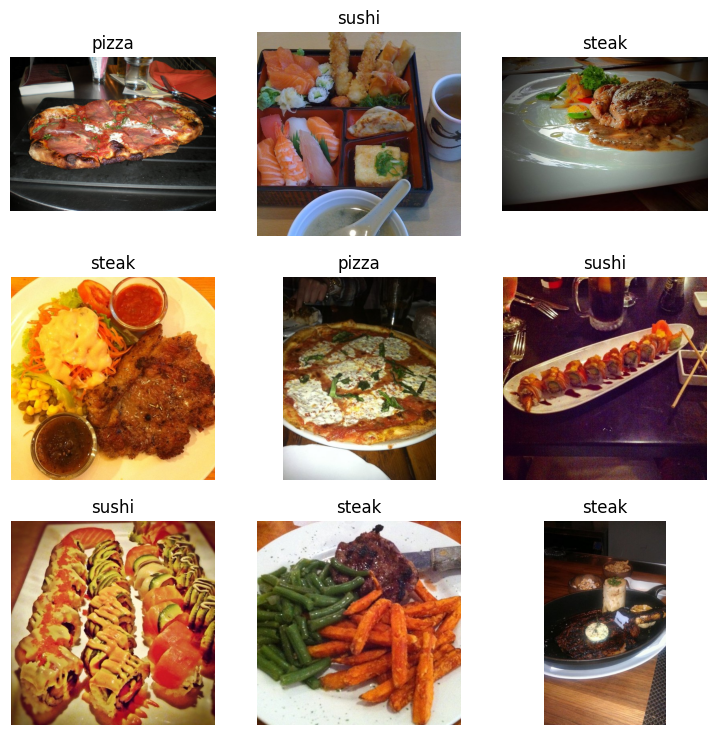

In [157]:
# show list of images
rows, cols = 3, 3
img_rng = range(1, rows * cols +1)
fig  = plt.figure(figsize = (9,9))
for i in img_rng:
    random.seed()
    img_path = random.choice (image_path_list)
    image_class = img_path.parent.stem
    img = Image.open(img_path)
    fig.add_subplot(rows, cols, i)
    img_as_array = np.asarray(img)
    plt.imshow (img)
    plt.title (image_class)
    plt.axis(False)
    print (img_as_array.shape)
    
    
    
    



In [158]:
# transforming data in pytorch tensors
# turn to torch to torch Dataset and DataLoader

In [159]:
# create transform
data_transform = transforms.Compose([
    transforms.Resize(size = (64,64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
    
])
img_torch = data_transform(img)
img_torch.dtype

torch.float32

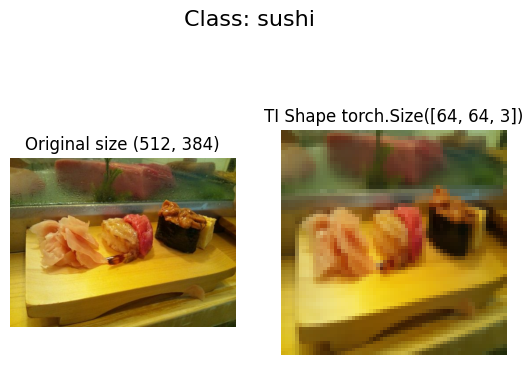

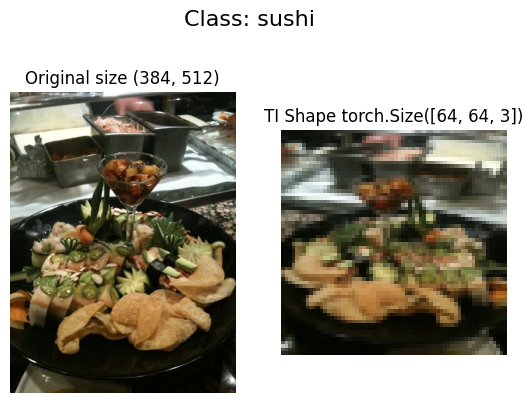

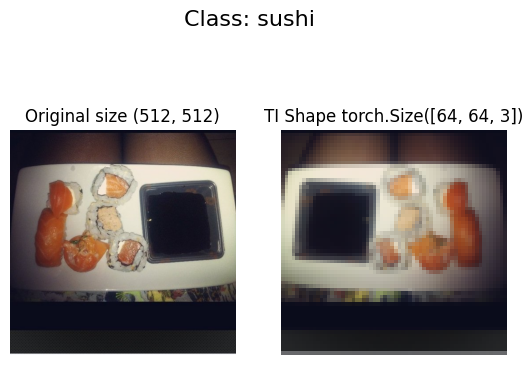

In [160]:
# visualize the transforms
def plot_transformed_images (image_paths, transform, n =3, seed = None):
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k = 3)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            # plot original
            fig, ax = plt.subplots(nrows = 1, ncols = 2 )
            ax[0].imshow(f)
            ax[0].set_title(f'Original size {f.size}')
            ax[0].axis(False)
            
            # show transfored
            transformed_image = transform (f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'TI Shape {transformed_image.shape}')
            ax[1].axis ('off')
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
        
    
plot_transformed_images (image_paths = image_path_list, transform = data_transform)


## load dataset using ImageFolder

In [161]:
# use image  folder
train_data = datasets.ImageFolder(root = train_dir,
                                  transform=data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform=data_transform)

train_data, test_data
class_names = train_data.classes

Text(0.5, 1.0, 'pizza')

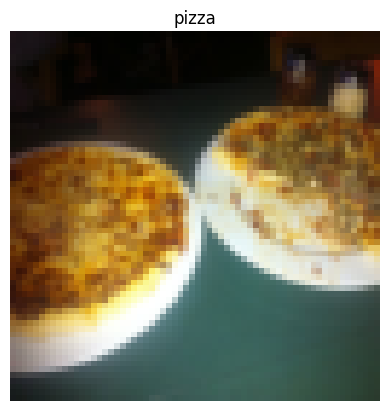

In [162]:
# visualize train data data
img, label = train_data[0]
img, label
img_permute = img.permute(1,2, 0)
plt.imshow(img_permute)
plt.axis('off')
plt.title (class_names[label])

## dataloader



In [163]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset = train_data,
                                batch_size = BATCH_SIZE,
                                num_workers=os.cpu_count(),
                                shuffle = True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
len(train_data), len(test_data)

(450, 150)

In [164]:
img, label = next(iter(train_dataloader))
img.shape

torch.Size([16, 3, 64, 64])

## Creating own custom dataset

### helper function to get class names

In [165]:
target_directory = train_dir
class_names_found = sorted([entry.name for entry in list (os.scandir(target_directory))])
class_names_found

# target_directory = train_dir
# class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
# class_names_found

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(target_directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f'classes not found in director')
    class_to_idx  = {class_name: i for i, class_name in enumerate(classes)}
    
    return classes, class_to_idx
    
find_classes(target_directory)  

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### creat cusom dataset

In [166]:
# create torchutis
class ImageFolderCustom(Dataset):
    # initialize
    def __init__(self, targ_dir: str, 
                 transform=None):
        # get image paths
        self.paths = list (pathlib.Path(targ_dir).glob("*/*.jpg"))
        # set up transfor
        self.transform = transform
        # set up classes and class_to_idx
        self.classes, self.class_to_idx  = find_classes(targ_dir)
        
     # load images   
    def load_image (self, index: int)->Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
     
    def __getitem__ (self, index: int) -> Tuple[torch.Tensor, int]:
        
        img =self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        # transform if necess
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
        
    
    

In [167]:
# test the daat class
train_transforms = transforms.Compose([
                                    transforms.Resize(size = (64,64)),
                                    transforms.RandomHorizontalFlip(p=.5),
                                    transforms.ToTensor()
    
                                    ])

test_transforms = transforms.Compose([
                                    transforms.Resize(size = (64, 64)),
                                    transforms.ToTensor()
                                    ])

In [168]:
# test image folder customer
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [169]:
# # get training data
# train_data = datasets.Food101(root=data_dir,
#                               split='train',
#                               download=True)

# # Get testing data
# test_data = datasets.Food101(root=data_dir,
#                              split='test',
#                              download=True)

In [170]:
len(train_data_custom), len(test_data_custom)
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [171]:
# check for equality
print(test_data.classes==test_data_custom.classes)

True


In [172]:
# # test image folder customer
# train_data_custom = ImageFolderCustom(targ_dir = train_dir,
#                                       transform=train_transforms)

# test_data_custom = ImageFolderCustom()

### visualzie

In [173]:
def display_random_images(dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int= 10,
                           display_shape: bool = True,
                           seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        
    if seed:
        random.seed(seed)
    
    random_samples_idx = random.sample(range(len(dataset)), k = n)
    
    plt.figure (figsize = (16,8))
    
    for i, targ_sample  in enumerate(random_samples_idx):
        targ_image, targ_targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # print (f'targ_image, shape{targ_image.shape}')   
        targ_image_adjust = targ_image.permute(1,2,0)
        
        plt.subplot (1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis ('off')
        if classes:
            title = f'Class: {classes[targ_targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'  
        plt.title(title)    


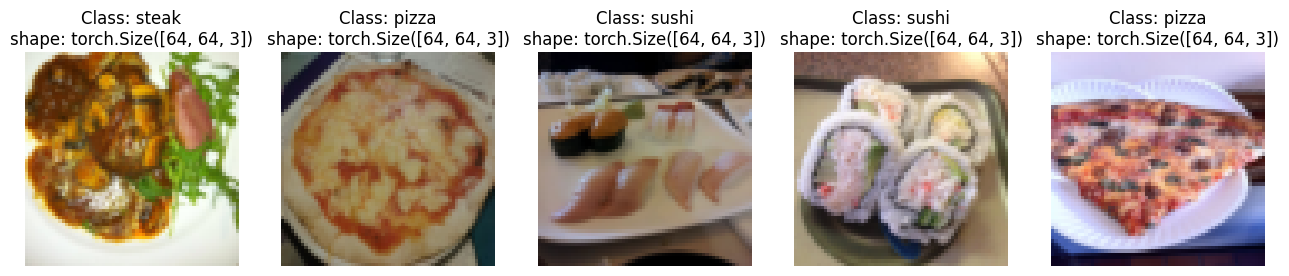

In [174]:
display_random_images(train_data,
                      n = 5,
                      classes = class_names,
                      seed=None)

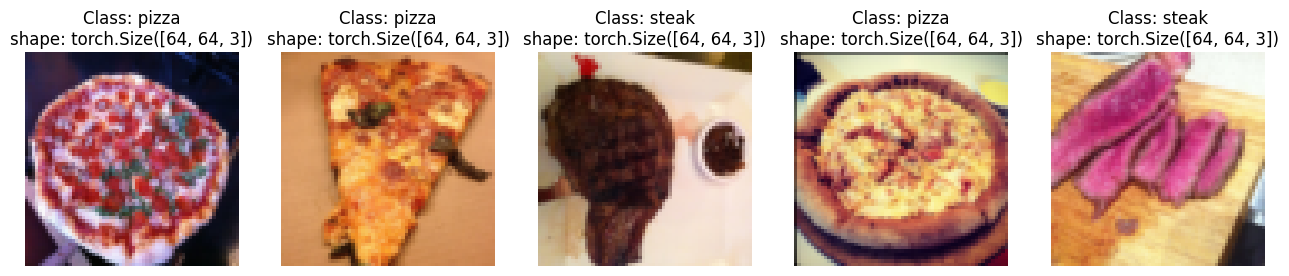

In [175]:
display_random_images(train_data_custom,
                      n = 5,
                      classes = class_names,
                      seed=None)

In [176]:
BATCH_SIZE = 25
train_dataloader_custom = DataLoader(dataset = train_data_custom,
                              batch_size = BATCH_SIZE,
                            #   num_workers = os.cpu_count(),
                              shuffle = True                   
                              )

test_dataloader_custom = DataLoader(dataset = test_data_custom,
                             batch_size = BATCH_SIZE,
                            #  num_workers = os.cpu_count(),
                             shuffle = False)

In [177]:
img_custom, label_custom = next (iter (train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([25, 3, 64, 64]), torch.Size([25]))

## data augmentation

In [178]:
train_transform_aug = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_aug = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor()
])

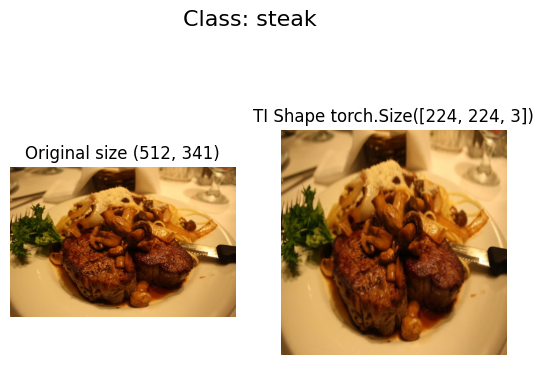

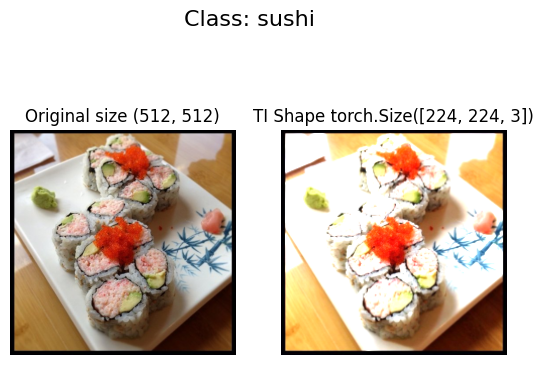

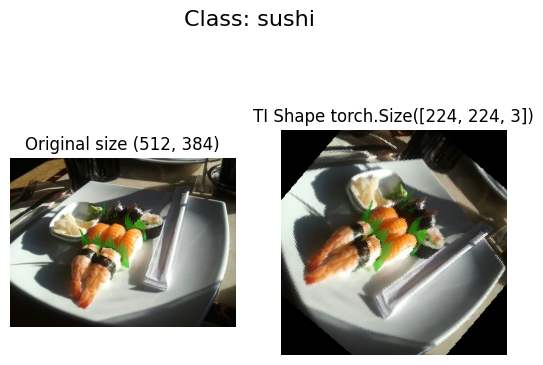

In [179]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform_aug,
    n = 3,
    seed = None
)

### My code classify these images

In [180]:
# set up length
out_shape = len(class_names)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)


cuda


In [181]:
# # do the CNN to classify into one of e classes
# class HassanFood(nn.Module):
#     def __init__ (self, input_shape, hidden_units, output_shape,
#                   in_ConvNN_ker_size: int = 3,
#                   in_ConvNN_stirde:int = 1,
#                   in_ConvNN_pad: int = 1,
#                   in_MAXP_KerSize: int = 4,
#                   in_MAXP_stride = 1,
#                   in_batch_size = 32):
#         super().__init__()
#         self.conv1= nn.Conv2d(
#                 in_channels = input_shape,
#                 out_channels = hidden_units,
#                 kernel_size = in_ConvNN_ker_size,
#                 stride = in_ConvNN_stirde,
#                 padding = in_ConvNN_pad 
#                 )
#         self.conv2 = nn.Conv2d(
#             in_channels = hidden_units,
#             out_channels=hidden_units,
#             kernel_size=in_ConvNN_ker_size,
#             stride=in_ConvNN_stirde,
#             padding=in_ConvNN_pad
#         )
#         self.relu = nn.LeakyReLU()
#         self.flatten = nn.Flatten()
#         self.maxpool = nn.MaxPool2d(kernel_size=in_MAXP_KerSize,
#                                     stride = in_MAXP_stride)
#         self.lazydense = nn.LazyLinear(out_features=output_shape)

#     def forward (self, x):
#         # first convolution and maxpool
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         # second convolution and maxpool
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         # flatten and send through dense linesr
#         x = self.flatten(x)
#         x = self.lazydense(x)

#         return (x)
    
# torch.manual_seed(42)
# model_custom_1 = HassanFood(input_shape = 3,
#                             hidden_units = 8,
#                             output_shape = out_shape).to(device)
# model_custom_1

In [182]:
# # do the CNN to classify into one of e classes
#  with model stacking to improve performance
class HassanFood(nn.Module):
    def __init__ (self, input_shape, hidden_units, output_shape,
                  in_ConvNN_ker_size: int = 3,
                  in_ConvNN_stirde:int = 1,
                  in_ConvNN_pad: int = 1,
                  in_MAXP_KerSize: int = 4,
                  in_MAXP_stride = 1,
                  in_batch_size = 32):
        super().__init__()
        self.conv1= nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = in_ConvNN_ker_size,
                stride = in_ConvNN_stirde,
                padding = in_ConvNN_pad 
                )
        self.conv2 = nn.Conv2d(
            in_channels = hidden_units,
            out_channels=hidden_units,
            kernel_size=in_ConvNN_ker_size,
            stride=in_ConvNN_stirde,
            padding=in_ConvNN_pad
        )
        self.relu = nn.LeakyReLU()
        self.flatten = nn.Flatten()
        self.maxpool = nn.MaxPool2d(kernel_size=in_MAXP_KerSize,
                                    stride = in_MAXP_stride)
        self.lazydense = nn.LazyLinear(out_features=output_shape)

    def forward (self, x):
        x = self.lazydense(self.flatten(self.maxpool(self.relu(self.conv2(self.maxpool(self.relu(self.conv1(x))))))))
#         # first convolution and maxpool
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         # second convolution and maxpool
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         # flatten and send through dense linesr
#         x = self.flatten(x)
#         x = self.lazydense(x)

        return (x)
    
torch.manual_seed(42)
model_custom_1 = HassanFood(input_shape = 3,
                            hidden_units = 8,
                            output_shape = out_shape).to(device)
model_custom_1

c:\Users\Hassan\anaconda3\envs\Py310UdemyCuda\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


HassanFood(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (maxpool): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (lazydense): LazyLinear(in_features=0, out_features=3, bias=True)
)

In [183]:
# class HassanCNN(nn.Module):
#     def __init__ (self,input_shape, hidden_units, output_shape,
#             in_conv_k_size:int = 3,
#             in_stride:int = 1,
#             in_pad:int = 1,
#             in_maxp_k_size = 2,
#             in_maxp_stride = 2,
#             in_batch_size = 32):
#         super().__init__()
#         self.conv1 = nn.Conv2d(
#                             in_channels = input_shape,
#                             out_channels = hidden_units,
#                             kernel_size=in_conv_k_size,
#                             stride = in_stride,
#                             padding = in_pad)
#         self.conv2 = nn.Conv2d(
#                             in_channels = hidden_units,
#                             out_channels = hidden_units,
#                             kernel_size=in_conv_k_size,
#                             stride = in_stride,
#                             padding = in_pad)
#         self.relu = nn.ReLU()

#         self.maxpool = nn.MaxPool2d(kernel_size=in_maxp_k_size,
#                                     stride = in_maxp_stride)
#         self.flatten = nn.Flatten()
#         # self.linear = nn.Linear()
#         self.lazydense = nn.LazyLinear(out_features = output_shape)

#     def forward (self, x):
#         # first block
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

        

#         # second block
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         # flatten
#         # linear_output = x.size(1) * x.size(2) * hidden_units
#         x = self.flatten(x)
#         # flattened_size = x.view(in_batch_size, -1).size(1)
#         # flattened_features = hidden_units * flattened_size
#         # flattened_feature = x.shape[0] * x.shape[1]
#         x = self.lazydense (x)
#         return x

# torch.manual_seed(42)
# model_has1 = HassanCNN(input_shape = 3,
#                        hidden_units = 512,
#                        output_shape = 3).to(device)

# model_has1

In [184]:
# create dataset
train_data_aug = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transform_aug)

test_data_aug = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform_aug)

In [185]:
X, y = train_data_aug [0]
X = X.to(device)
pred = model_custom_1(X.unsqueeze(dim = 0))
# pred = model_has1(X.unsqueeze(dim = 0))
pred

tensor([[ 0.0253, -0.0261, -0.0083]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [186]:
X.shape

torch.Size([3, 224, 224])

## Train it

In [187]:
# loss and optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_custom_1.parameters(), lr = 0.01)

In [188]:
# timer
def print_train_time (start:float,
                      end: float,
                      device:torch.device = None):
    total_time = end - start
    print (f'Total tiem {device}: {total_time:.3f} seconds')
    return total_time

In [189]:
import torch.utils
import torch.utils.data

# redo this one  to handle epocs
def train_loop (model: nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device:torch.device=device):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_train_pred = model(X)
        loss = loss_fn (y_train_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true = y,
                                 y_pred = y_train_pred.argmax(dim = 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print (f'Train Loss {train_loss:.4f} - train acc {train_acc:.2f}')


def test_loop(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device:torch.device = device):
    
    test_loss = 0
    test_acc = 0
    model.eval()
    for batch, (X, y)in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_test_pred = model(X)
        test_loss += loss_fn (y_test_pred, y)
        test_acc += accuracy_fn(y_true = y, 
                                y_pred = y_test_pred.argmax(dim = 1))
        
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print (f'Test Loss {test_loss:.4f} - Test acc {test_acc:.2f}')



In [190]:
# create dataloaders
BATCH_SIZE = 8
train_dataloader_aug = DataLoader(dataset = train_data_aug,
                              batch_size = BATCH_SIZE,
                            #   num_workers = os.cpu_count(),
                              shuffle = True                   
                              )

test_dataloader_aug = DataLoader(dataset = test_data_aug,
                             batch_size = BATCH_SIZE,
                            #  num_workers = os.cpu_count(),
                             shuffle = False)

In [191]:
# # X, y = next(iter(train_dataloader_aug))
# # X, y = X.to(device), y.to(device)
# # y_train_pred = model_custom_1(X)
# # y_train_pred

# # X, y = train_data_aug [0]
# X, y = train_data_custom[0]
# X = X.to(device)
# pred = model_custom_1(X.unsqueeze(dim = 0))
# pred, y
# # X.shape, y

In [192]:
# run through coe

torch.manual_seed(42)
train_start_time_model_custom_1 =timer ()
epochs = 100
range_epochs = range (epochs)
for epoch in tqdm(range_epochs):
    print (f'Epoch: {epoch}\n')
    train_loop (model = model_custom_1,
                dataloader = train_dataloader_aug,
                loss_fn = loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn
                 )

    test_loop (model = model_custom_1,
               dataloader = test_dataloader_aug,
               loss_fn = loss_fn,
               accuracy_fn=accuracy_fn)
    
train_end_time_model_custom_1 = timer()

tot_time_model_custom_1 = print_train_time(start =train_start_time_model_custom_1,
                                           end = train_end_time_model_custom_1,
                                            device = device )


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0

Train Loss 1.5118 - train acc 32.24
Test Loss 1.0942 - Test acc 38.16
Epoch: 1

Train Loss 1.1027 - train acc 30.92
Test Loss 1.0939 - Test acc 36.84
Epoch: 2

Train Loss 1.0999 - train acc 33.11
Test Loss 1.0982 - Test acc 32.89
Epoch: 3

Train Loss 1.0978 - train acc 35.75
Test Loss 1.0981 - Test acc 32.89
Epoch: 4

Train Loss 1.0946 - train acc 40.13
Test Loss 1.0998 - Test acc 37.06
Epoch: 5

Train Loss 1.0940 - train acc 39.25
Test Loss 1.0981 - Test acc 32.46
Epoch: 6

Train Loss 1.0950 - train acc 37.72
Test Loss 1.0975 - Test acc 32.46
Epoch: 7

Train Loss 1.0924 - train acc 40.79
Test Loss 1.0934 - Test acc 37.50
Epoch: 8

Train Loss 1.0941 - train acc 39.25
Test Loss 1.0912 - Test acc 43.42
Epoch: 9

Train Loss 1.0912 - train acc 40.79
Test Loss 1.0906 - Test acc 42.11
Epoch: 10

Train Loss 1.0878 - train acc 45.83
Test Loss 1.0895 - Test acc 42.32
Epoch: 11

Train Loss 1.0616 - train acc 41.01
Test Loss 1.0535 - Test acc 44.96
Epoch: 12

Train Loss 1.0021 - train a

## code to do get cumulative to plot with each loop

In [193]:
def train_step (model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0,  0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn (y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim= 1)
        train_acc  += (y_pred_class == y).sum().item()/len(y_pred)
        
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc /len(dataloader)
    return train_loss, train_acc

In [194]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    model.eval()
    
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn (test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_loss = test_loss/ len(dataloader)
    test_acc = test_acc / len (dataloader)
    return test_loss, test_acc

In [195]:
def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader:torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
                epochs: int = 1):
    results = {'train_loss':[],
               'train_acc': [],
               'test_loss':[],
               'test_acc':[]}
    
    range_epochs = range(epochs)
    for epoch in tqdm(range_epochs):
        train_loss, train_acc = train_step(model=model,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step (model=model,
                                        dataloader=test_dataloader,
                                        loss_fn = loss_fn)
        
        if epoch % 10 == 0:
            print (
                f'Epoch: {epoch+1} |'
                f'train_loss: {train_loss:.4f} |'
                f'train_acc:{train_acc:.4f} | '
                f'test_loss: {test_loss:.4f} | '
                f'test_acc: {test_acc:.4f}'
            )
            
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        
    return results

### train and evaluate

In [196]:
# run test
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

start_time = timer()

model_cutom_1_aug1 = train_model (model = model_custom_1,
                                  train_dataloader=train_dataloader_aug,
                                  test_dataloader=train_dataloader_aug,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=NUM_EPOCHS)

end_time = timer()

print(f'total training time : {end_time-start_time:.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.5250 |train_acc:0.7961 | test_loss: 0.5162 | test_acc: 0.8070
Epoch: 11 |train_loss: 0.4357 |train_acc:0.8224 | test_loss: 0.4976 | test_acc: 0.8246
Epoch: 21 |train_loss: 0.4995 |train_acc:0.8004 | test_loss: 0.4590 | test_acc: 0.8443
Epoch: 31 |train_loss: 0.4642 |train_acc:0.7895 | test_loss: 0.4941 | test_acc: 0.8202
Epoch: 41 |train_loss: 0.4555 |train_acc:0.8158 | test_loss: 0.6633 | test_acc: 0.7566
Epoch: 51 |train_loss: 0.4661 |train_acc:0.8289 | test_loss: 0.4072 | test_acc: 0.8377
Epoch: 61 |train_loss: 0.4278 |train_acc:0.8224 | test_loss: 0.4177 | test_acc: 0.8509
Epoch: 71 |train_loss: 0.4673 |train_acc:0.8333 | test_loss: 0.5109 | test_acc: 0.7873
Epoch: 81 |train_loss: 0.4479 |train_acc:0.8311 | test_loss: 0.4151 | test_acc: 0.8311
Epoch: 91 |train_loss: 0.4870 |train_acc:0.8180 | test_loss: 0.3716 | test_acc: 0.8509
total training time : 2377.795


In [197]:
def plot_loss_curves (results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    
    accuracy = results['train_acc']
    test_accuracy = results ['test_acc']
    
    epochs = range (len(results['train_loss']))
    
    plt.figure (figsize=(15, 7))
    
    plt.subplot (1,2, 1)
    plt.plot (epochs, loss, label = 'train_loss')
    plt.plot(epochs, test_loss, label = 'test__loss')
    plt.title ('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = 'train_accuracy')
    plt.plot(epochs, test_accuracy, label= 'test_accuracy')
    plt.title ('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    

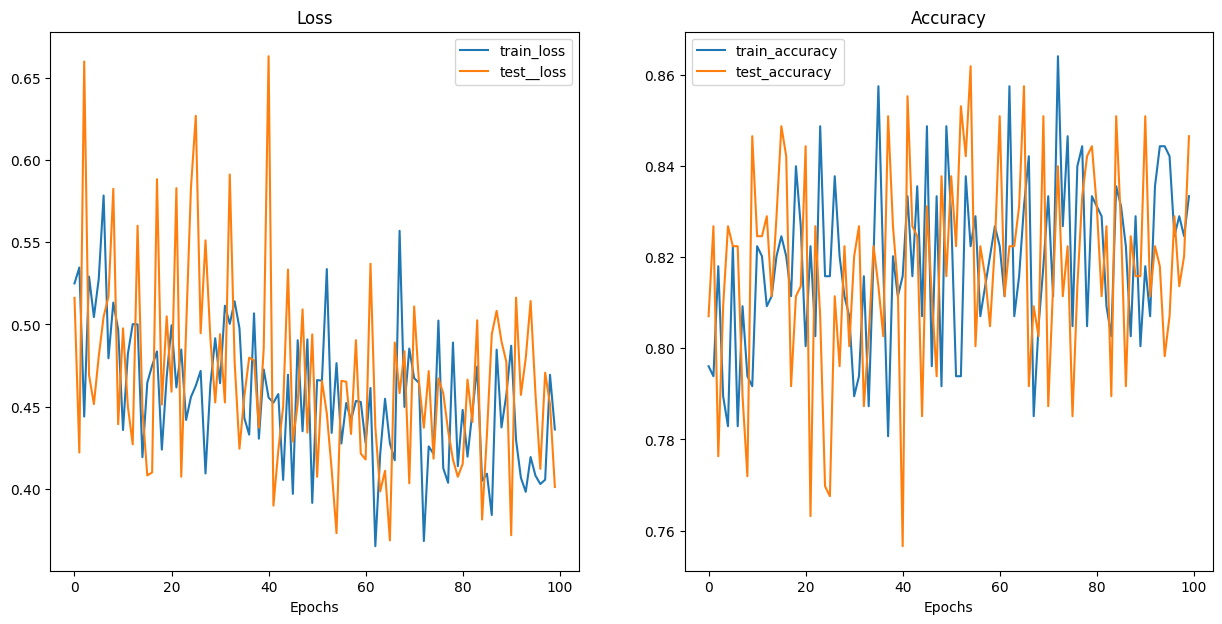

In [198]:
plot_loss_curves(model_cutom_1_aug1)

### load custom image

In [199]:
custom_image_path = data_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get ("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print (f'downloading {custom_image_path}...')
        f.write(request.content)
else:
    print (f'{custom_image_path} already exisits')

..\data\04-pizza-dad.jpeg already exisits


In [200]:
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
custom_image_unit8.shape, custom_image_unit8.dtype

(torch.Size([3, 4032, 3024]), torch.uint8)

In [201]:
# X, y = train_data_aug[0]
# X.shape

X, y = train_data_aug [0]
X = X.to(device)
pred = model_custom_1(X.unsqueeze(dim = 0))
# pred = model_has1(X.unsqueeze(dim = 0))
X.shape

torch.Size([3, 224, 224])

In [202]:
train_data_aug[0][0].shape, resized_img.shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [203]:
model_custom_1.eval()
resized_transform = transforms.Resize((224,224))
resized_img =resized_transform(custom_image_unit8).float().to(device)
resized_img.shape
with torch.inference_mode():
    # model_custom_1(resized_img)
    # model_custom_1(train_data_aug[0][0].unsqueeze(dim = 0).to(device))
    pred = model_custom_1(resized_img.unsqueeze(dim = 0).to(device))

class_names[pred.argmax(dim = 1)], torch.softmax(pred, dim = 1)

('pizza', tensor([[1., 0., 0.]], device='cuda:0'))

## Evaluate Model

In [204]:
torch.manual_seed(42)
def eval_model (model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model (X)
            loss += loss_fn (y_pred, y)
            acc += accuracy_fn(y_true = y,
                               y_pred = y_pred.argmax(dim=1))
            
        loss /= len(dataloader)
        acc /= len (dataloader)

    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}

In [205]:
model_cust1_aug = eval_model(model = model_custom_1,
                             dataloader=test_dataloader_aug,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)

model_cust1_aug 


{'model_name': 'HassanFood',
 'model_loss': 1.43702232837677,
 'model_acc': 47.58771929824561}

## Display retusl

In [206]:
test_img, test_label = test_data_aug[0]
test_img.squeeze().permute(1,2,0).shape

torch.Size([224, 224, 3])

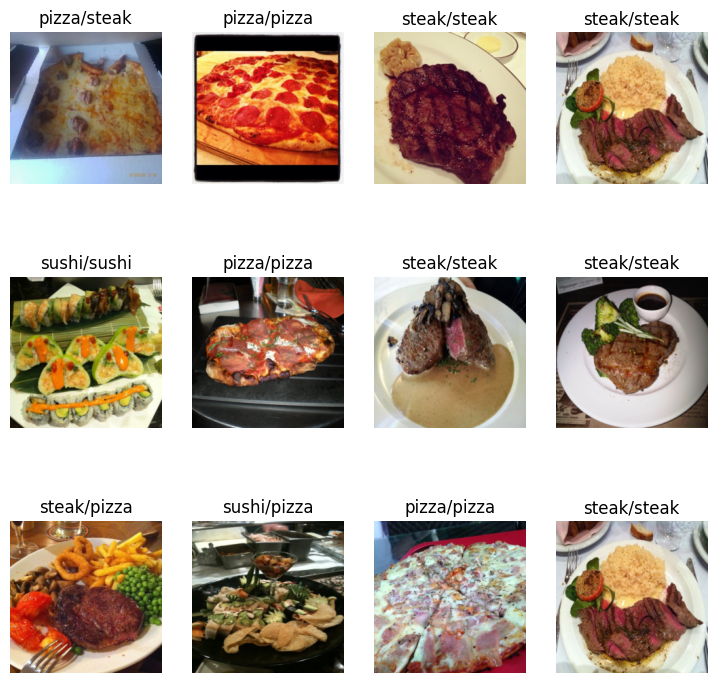

In [207]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
model_custom_1.eval()
rows, cols = 3, 4
range_pics = range (1, rows * cols + 1)
with  torch.inference_mode():
    for i in range_pics:
        rand_index = torch.randint(0, len (test_data_aug), size =[1]).item()
        img, label = test_data_aug[rand_index]
        unsqz_img = torch.unsqueeze(img, dim = 0).to(device)
        pred_label = model_custom_1(unsqz_img).argmax(dim = 1)
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.squeeze().permute(1,2,0))
        plt.title(class_names[label] + '/' + class_names[pred_label])
        plt.axis(False)


## confusion matrix

In [208]:
y_preds = []
model_custom_1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader_aug, desc = 'Predictions with augmented data'):
        X, y = X.to(device), y.to(device)
        y_logit = model_custom_1(X)
        y_pred = torch.softmax(y_logit, dim = 1).argmax(dim = 1)
        y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)


Predictions with augmented data:   0%|          | 0/19 [00:00<?, ?it/s]

In [209]:
test_data.classes
# try torchinfo
#  also try modelstacking
#  also do loss curves. 
# handle epocs. 

['pizza', 'steak', 'sushi']

In [210]:
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(12,9)
)

AttributeError: 'list' object has no attribute 'ndim'